Данное исследование проводится для интернет-магазина с целью подготовки модели машинного обучения, которая будет предсказывать вероятность совершения покупателем покупки в течение 90 дней.

Необходимо:
- Изучить данные, провести их предобработку (при наличии и по возможности избавиться от выбросов и аномалий, заполнить пропущенные значения, т.д.).
- Провести исследовательский анализ.
- При необходимости сформировать новые признаки.
- Проверить данные на мультиколлинеарность.
- Подготовить и обучить модель на имеющихся данных.
- Оценить работу модели по метрике качества и максимизировать ее по возможности.

В данном проекте будет использоваться метрика ROC-AUC для определения качества работы модели.

In [333]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Подготовка и анализ данных

## Загрузка и ознакомление с данными

Загрузим имеющиеся у нас данные и предварительно рассмотрим их.

У нас имеются:
- История покупок (apparel-purchases) - содержит данные по дням и по товарам, в каждой записи покупка определенног товара, его цена и количество штук.
- История рекламных рассылок (apparel-messages) - содержит данные по рассылкам клиентам из Истории покупок.
- Таблица с целевыми значениями (apparel-target_binary).

In [256]:
df = pd.read_csv('DS/apparel-purchases.csv')
target = pd.read_csv('DS/apparel-target_binary.csv')

messages = pd.read_csv('DS/apparel-messages.csv')

### Датасет df

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [258]:
df.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459458e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


In [259]:
df.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


Отметим следующее:
- Явных пропусков нет.
- Столбец date имеет тип object, вместо ожидаемого datetime. Возможно потребует корректировки.
- В столбце quantity потенциально аномальное распределение данных (от минимума до 3 квартиля значение 1, а максимальное - 30).
- В столбце price также широкий диапазон данных, с явным смещение в сторону минимума.

### Датасет target

In [260]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [261]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [262]:
target['client_id'].nunique()

49849

In [263]:
target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

Отметим, что данные в целевом столбце имеют корректный вид. В столбце с id имеем только уникальные значения. Обратим внимание, что большинство клиентов не вернулись в течение 90 дней.

## Предобработка данных

Подготовим данные для дальнейшнего анализа.

Т.к. предварительно отметили отсутствие пропусков и потенциально релевантные значения данных, оценим, есть ли полные дубликаты в строках датасета.

In [264]:
df.duplicated().sum()

73020

Это 36% данных, т.е. больше 1/3 данных являются полными дубликатами. В случае удаления это будет недопустимо большая потеря данных.
Учтем, что в данном случае нет данных о времени покупки, а также в целом специфике интернет-магазина (какие категории товаров, работает он по системе B2B или B2C, т.д.). Соответственно, объективно нет возможности оценить, насколько такое покупательское поведение является стандартным для данной отрасли.

Ввиду значительности объема данных, сохраним их, т.к. на текущий момент не подтверждено, что эти данные являются ошибочными. С этого момента такое покупательское поведение в данном случае будет считаться как возможное.

Рассмотрим, как распределяются количества единиц товаров в дс data (столбец quantity).

In [265]:
df['quantity'].value_counts()

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

<Axes: >

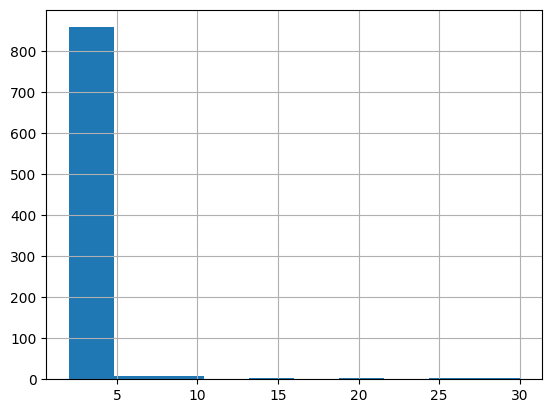

In [266]:
df['quantity'].hist(range=(2,30))

Как ранее отмечали, действительно видим перекос в распределении данных. Однако в данном случае мы не можем исключить какие-либо покупки, т.к. у нас нет оснований полагать, что клиент не может приобрести 8 или 18 едииниц товара. При этом то, что большинство товаров куплено в единичном количестве, является ожидаемым результатом. Соответственно, это данные не требуют корректировки.

Расмотрим покупки с потенциально аномально высокой стоимостью.

In [267]:
df[df['price']>60000]

,client_id,quantity,price,category_ids,date,message_id
166576,1515915625776653984,1,63499.0,"['4', '29', '310', '1577']",2023-08-26,1515915625776653984-13719-64e85f9332bc8
166578,1515915625776653984,1,60200.0,"['4', '29', '310', '1577']",2023-08-26,1515915625776653984-13719-64e85f9332bc8
186736,1515915625553309277,1,85499.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711


Отметим следующее:
1. Максимальное значение действительно ощутимо отличается от остальных. Необходимо рассмотреть, были ли иные покупки товара данной категории.
2. Первые две строки выведенного фрагмента дс показывают данные об одном и том же покупателе, который приобрел один и тот же товар в один и тот же день, однако их цена заметно отличается. Можем предположить, что после первой покупки клиент получил индивидуальную скидку или же в целом на сайте цена опустилась для всех, что сподвигло клиента приобрести также и второй точно такой же товар. В любом случае, потенциально такая ситуация возможна, хотя и потенциально может оказать негативное влияние на результаты предсказания модели.
3. Можем предположить, что дорогие товары относятя к общей категории (вероятно, дорогостоящей). Вероятно, высокая цена приводит к меньшему количеству покупок в общем числе товарооборота, в связи с этим цены кажутся аномально высокими на фоне остальных.

Перепроверим значения в столбце category_ids на корректность заполнения.

In [268]:
df['category_ids'].sort_values(ascending=False)

166755                           []
134545                           []
63462                            []
126143                           []
97964                            []
                    ...            
185211    ['2', '17', '107', '453']
146674    ['2', '17', '107', '453']
5990       ['1', '8', '280', '710']
22938      ['1', '22', '50', '685']
29809      ['1', '22', '50', '685']
Name: category_ids, Length: 202208, dtype: object

Обратим внимание, что в столбце есть скрытые пропуски (пустые категории).

In [269]:
#Для простоты работы преобразуем текущий список в действительно список целочисленных значений
#Для этого напишем функцию, преобразующую значения в список
def convert_to_int_list(s):
    s = s.strip("[]")  #Удаляем квадратные скобки
    el = s.split(", ")  #Разделяем строку на элементы
    #Ранее отметили наличие пустых строк, которые станут None на этом этапе. Пропускаем их
    int_e = []
    for e in el:
        try:
            int_value = int(e.strip("'"))
            int_e.append(int_value)
        except ValueError:
            pass  # Пропускаем элемент, если он не может быть преобразован в int
            
    return int_e

In [270]:
df['category_ids'] = df['category_ids'].apply(convert_to_int_list)

Оценим количество таких строк и посмотрим, есть ли в них что-то общее.

In [271]:
df[df['category_ids'].apply(set) == set([])]

,client_id,quantity,price,category_ids,date,message_id
14848,1515915625649908756,1,2499.0,[],2022-06-17,1515915625649908756-4981-62ac2dbf52fad
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
32281,1515915625578652401,1,8.0,[],2022-08-19,1515915625815834300-5922-62ff35494e05f
32282,1515915625578652401,1,8.0,[],2022-08-19,1515915625815834300-5922-62ff35494e05f
...,...,...,...,...,...,...
201990,1515915625641742458,1,7.0,[],2024-02-16,1515915625766077627-14668-65cf5246bd490
202068,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c
202069,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c
202144,1515915626007712189,1,12.0,[],2024-02-16,1515915626007712189-14648-65cdb6d1c0c2a


Отметим, что среди таких строк встречаются полные дубликаты. Можно предположить, что или товар был удален из базы и его id не сохранился, или данные были утеряны при формировании датасета, или данные строки являются некорректными и не отражают реальность (например, тестовые заказы, ошибочно включенные в выборку).

Проверим на примере первого клиента, посмотрим все его заказы по его id.

In [272]:
df[df['client_id']==1515915625649908756]

,client_id,quantity,price,category_ids,date,message_id
14847,1515915625649908756,1,2499.0,"[2, 18, 61, 661]",2022-06-17,1515915625649908756-4981-62ac2dbf52fad
14848,1515915625649908756,1,2499.0,[],2022-06-17,1515915625649908756-4981-62ac2dbf52fad
14849,1515915625649908756,1,2499.0,"[2, 18, 258, 1590]",2022-06-17,1515915625649908756-4981-62ac2dbf52fad
15256,1515915625649908756,1,999.0,"[5562, 5631, 5549, 667]",2022-06-18,1515915625649908756-4981-62ac2dbf52fad
124411,1515915625649908756,1,1999.0,"[2, 18, 258, 1590]",2023-05-26,1515915625649908756-12864-64708ae47f86b
124412,1515915625649908756,1,1999.0,"[2, 18, 258, 441]",2023-05-26,1515915625649908756-12864-64708ae47f86b
124413,1515915625649908756,1,1999.0,"[2, 18, 258, 441]",2023-05-26,1515915625649908756-12864-64708ae47f86b
124414,1515915625649908756,1,1999.0,"[2, 18, 212, 726]",2023-05-26,1515915625649908756-12864-64708ae47f86b
124415,1515915625649908756,1,1999.0,"[2, 18, 258, 1590]",2023-05-26,1515915625649908756-12864-64708ae47f86b
124416,1515915625649908756,1,1999.0,"[2, 18, 212, 726]",2023-05-26,1515915625649908756-12864-64708ae47f86b


Отметим, что это не единичный его заказ. Соответственно, вероятнее всего, id был удален случайно.
Присвоим таким строкам дефолтное значение [0, 0, 0, 0]

In [273]:
df['category_ids'] = df['category_ids'].apply(lambda x: [0, 0, 0, 0] if not x else x)

In [274]:
#Наконец, рассмотрим, были ли еще покупки аномально дорогого товара за исследуемый период
target_set = set([4, 29, 313, 1574])
df[df['category_ids'].apply(set) == target_set]

,client_id,quantity,price,category_ids,date,message_id
12994,1515915625494529950,1,16499.0,"[4, 29, 313, 1574]",2022-06-10,1515915625494529950-4832-62a1969869bb0
98921,1515915625474387397,1,16660.0,"[4, 29, 313, 1574]",2023-04-05,1515915625474387397-11527-642c1f61cbd80
98922,1515915625474387397,1,16660.0,"[4, 29, 313, 1574]",2023-04-05,1515915625474387397-11527-642c1f61cbd80
142203,1515915625468081528,1,22680.0,"[4, 29, 313, 1574]",2023-06-20,1515915625468081528-13372-649150b651ec0
142204,1515915625468081528,1,22680.0,"[4, 29, 313, 1574]",2023-06-20,1515915625468081528-13372-649150b651ec0
155219,1515915625590727241,1,15049.0,"[4, 29, 313, 1574]",2023-07-07,1515915625776568054-13456-64a7dde275979
155220,1515915625590727241,1,15049.0,"[4, 29, 313, 1574]",2023-07-07,1515915625776568054-13456-64a7dde275979
159176,1515915625502430512,1,13999.0,"[4, 29, 313, 1574]",2023-07-13,1515915625776547099-13471-64abf25c6fe22
159177,1515915625502430512,1,13999.0,"[4, 29, 313, 1574]",2023-07-13,1515915625776547099-13471-64abf25c6fe22
159465,1515915625776547099,1,19999.0,"[4, 29, 313, 1574]",2023-07-13,1515915625776547099-13471-64abf25c6fe22


Покупки были, при этом отметим большой разброс цен на товар. Очевидно, что категория не указывает в конечном счете на конкретный товар, а демонстрирует достаточно широкий диапазон товаров разной ценовой категории.

Следовательно, оставляем данное значение, т.к. потенциально в дальнейшем модель может сталкиваться с товарами очень разного ценового сегмента.

Т.к. в сопроводительной информации указывалось, что количество значений в списке в данном столбце иногда может стать меньше 4, рассмотрим, сколько в целом сейчас таких данных в датасете.

In [275]:
df[df['category_ids'].apply(lambda x: len(x) < 4)]

,client_id,quantity,price,category_ids,date,message_id
55348,1515915625489465791,1,193.0,"[4, 44, 428]",2022-11-15,1515915625489465791-7845-6373358bbb68e
55349,1515915625489465791,1,193.0,"[4, 44, 428]",2022-11-15,1515915625489465791-7845-6373358bbb68e
56942,1515915625602272264,1,28.0,"[4, 44, 1594]",2022-11-15,1515915625491914808-7845-637335966f02d
56943,1515915625602272264,1,28.0,"[4, 44, 1594]",2022-11-15,1515915625491914808-7845-637335966f02d
57592,1515915625468142032,1,39.0,"[4, 44, 1594]",2022-11-16,1515915625468142032-7816-6371eb13cdaed
...,...,...,...,...,...,...
201643,1515915625585044070,1,199.0,"[4, 44, 430]",2024-02-15,1515915625585044070-14656-65cdbea44cf9e
202022,1515915625780975466,1,69.0,"[4, 44, 491]",2024-02-16,1515915625780975466-14648-65cdb6ee6aaf8
202023,1515915625780975466,1,69.0,"[4, 44, 491]",2024-02-16,1515915625780975466-14648-65cdb6ee6aaf8
202028,1515915625785777568,1,99.0,"[4, 29, 503]",2024-02-16,1515915625785777568-14628-65c9ec6d23ac1


In [276]:
df[df['category_ids'].apply(lambda x: len(x) < 4)]['category_ids'].value_counts()

category_ids
[4, 44, 428]          223
[4, 44, 501]          177
[4, 44, 1381]         159
[4, 44, 491]          141
[4, 44, 1594]         130
[4, 44, 489]           93
[4, 44, 430]           87
[4, 44, 490]           77
[4, 44, 1097]          42
[4, 44, 549]           35
[4, 44, 493]           27
[4, 44, 1564]          26
[4, 44, 1571]          25
[4, 29, 503]           24
[4, 44, 989]           17
[4, 44, 528]           16
[4, 44, 494]           16
[5562, 5597, 5782]     14
[4, 44, 492]           11
[4, 30, 503]            8
[4, 1822, 499]          7
[4, 44, 1600]           1
Name: count, dtype: int64

Данных немного, однако отметим, что они встречаются за разные периоды времени (и за 2022 год, и за 2024). Визуально проблематично предположить, какой именно уровень вложения был утерян. Однако, предположительно, утеряно не первое значение. Соответственно, для единообразия, преобразуем данные id категорий, дополнив их необходимым количеством нулей на конце.

In [277]:
df['category_ids'] = df['category_ids'].apply(lambda x: x + [0] * (4 - len(x)))

Теперь все значения в данном столбце приведены к единому виду.

Наконец, приведем столбец date к корректному виду

In [278]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')

## Исследовательский анализ данных

Для начала оценим в целом, как распределяются данные по ценам на товары:

<Axes: >

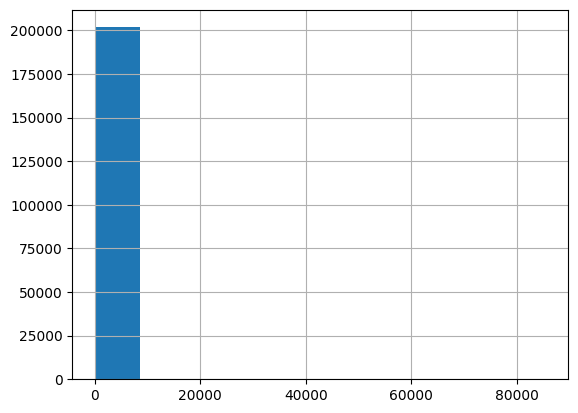

In [279]:
#В целом
df['price'].hist()

<Axes: >

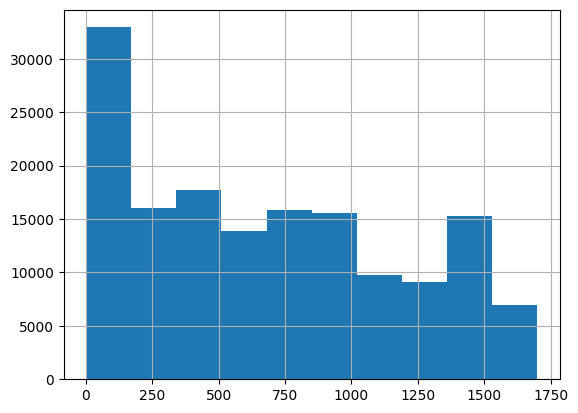

In [280]:
#В диапазоне до 3 квартиля
df['price'].hist(range=(1, 1699))

<Axes: >

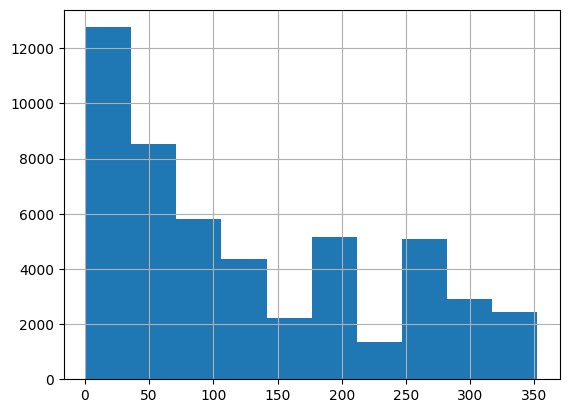

In [281]:
#В диапазоне до 1 квартиля
df['price'].hist(range=(1, 352))

Очевидно, что в основном интернет-магазин торгует достаточно недорогими товарами. Однако учтем, что это цена за единицу товара. Соответственно, эти данные не отражают реальную сумму чека покупателя. Кроме того, как ранее установили, в ряде случаев клиенты снова покупают тот же самый товар в этот же день, а также, что цены на один и тот же товар могут сильно разнится (даже в рамках одного дня). Соответственно, цены не отражают реальный уровень денежного оборота и, возможно, в текущем виде не позволят модели более объективно рассматривать данные.

Соответственно, потенциально можем в дальнейшем (при низких результатах работы модели) попробовать улучшить ее работу преобразованием данных с группировкой их по пользователям.

Но уже на текущий момент можем добавить столбец "сумма покупки" для упрощения дальнейшего анализа данных.

In [282]:
df['total'] = df['price'] * df['quantity']

df.head()

,client_id,quantity,price,category_ids,date,message_id,total
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,6499.0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0


Оценим, как в целом распределяются покупки по количеству и сумме по годам.

In [283]:
df_t = df
df_t['year'] = df_t['date'].dt.year

df_t_gb = df_t.groupby('year')[['quantity', 'total']].sum()
df_t_gb

,quantity,total
year,,
2022,82410,107092805.0
2023,110167,122146448.0
2024,10942,13305257.0


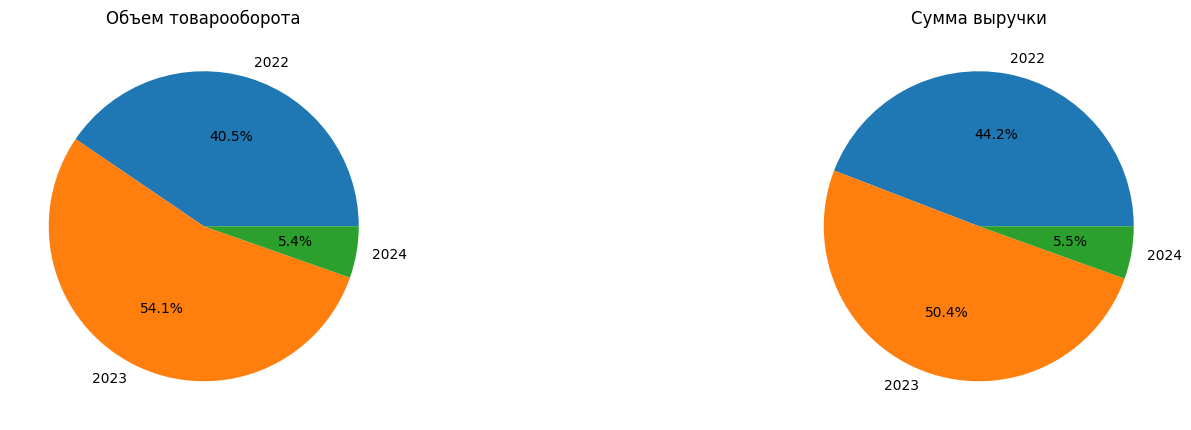

In [284]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
plt.subplots_adjust(wspace=1)

axes[0].pie(df_t_gb['quantity'], autopct='%1.1f%%', labels=df_t_gb['quantity'].index)
axes[0].set_title('Объем товарооборота')

axes[1].pie(df_t_gb['total'], autopct='%1.1f%%', labels=df_t_gb['total'].index)
axes[1].set_title('Сумма выручки')


plt.show()

Отметим как рост товарооборота, так и выручки с 2022 на 2023 год. При этом отметим, что в относительных значениях количество покупаемых товаров выросло значительнее чем объем выручки. Вероятно, это связано с особенностями ценообразования, а также общей ценовой и ассортиментной политикой.

Однако доля 2024 года слишком незначительна. Вероятно, это связано с нехваткой данных за текущий год. Проверим, сколько в целом имеется покупок за каждый из годов.

In [285]:
df_t.groupby('year')['client_id'].count()

year
2022     81621
2023    109680
2024     10907
Name: client_id, dtype: int64

Действительно, за 2024 год данных значительно меньше, а 2023 показал прирост к 2022. Однако возможно это связано не с увеличением количества покупок старыми клиентами, а притоком новых.

Оценим количество уникальных клиентов за каждый год.

In [286]:
df_t.groupby('year')['client_id'].nunique()

year
2022    25459
2023    24561
2024     2517
Name: client_id, dtype: int64

Отметим, что в 2023 году количество уникальных клиентов уменьшилось практически на 1 тысячу в сравнении с 2022. Следовательно, может предполагать (с учетом общего количества покупок, трех квартилей количества покупаемых товаров и количества уникальных покупателей), что либо вырос средний чек (покупатель за раз приобретает больше товаров), либо они стали чаще возвращаться.

Вероятнее первое, т.к. в дс target ранее отмечали, что подавляющее большинство клиентов не возвращаются. Вероятно, обучение модели и оценка значимости признаков позволит выявить неявные на текущем этапе закономерности, которые позволят улучшить маркетинговые активности.

In [287]:
df_t_gb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 2022 to 2024
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   quantity  3 non-null      int64  
 1   total     3 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 60.0 bytes


## Проверка данных на мультиколлинеарность

Корреляционный анализ будем проводить с помощью построения матрицы phik, т.к. она учитывает не только количественные, но и качественные признаки.

Оценим текущие данные на наличие мультиколлинеарности. Исключаем столбцы client_id и message_id из-за их большого объема уникальных значений, но малой информативности в текущем виде для модели.

Т.к. в исходных данных есть столбец category_ids, имеющий тип данных list, построить матрицу с ним не получится. Однако возможно наличие взаимосвязи этого параметра с, например, ценой, соответственно эти данные необходимо также рассмотреть. Кроме того, нам известно, что нумерация категорий сквозная, т.е. одно и тоже число на разных уровнях будет означать одну и ту же категорию/подкатегорию. Соответственно, для анализа сформируем отдельный датасет, в котором разобъем category_ids на отдельные строки.

In [288]:
df = df.explode('category_ids')
df

,client_id,quantity,price,category_ids,date,message_id,total,year
0,1515915625468169594,1,1999.0,4,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,2022
0,1515915625468169594,1,1999.0,28,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,2022
0,1515915625468169594,1,1999.0,57,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,2022
0,1515915625468169594,1,1999.0,431,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,2022
1,1515915625468169594,1,2499.0,4,2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0,2022
...,...,...,...,...,...,...,...,...
202206,1515915626010443527,1,1999.0,446,2024-02-16,1515915625766077627-14668-65cf5246bd490,1999.0,2024
202207,1515915626010443624,1,999.0,4,2024-02-16,1515915625488468007-14668-65cf5234b1295,999.0,2024
202207,1515915626010443624,1,999.0,28,2024-02-16,1515915625488468007-14668-65cf5234b1295,999.0,2024
202207,1515915626010443624,1,999.0,62,2024-02-16,1515915625488468007-14668-65cf5234b1295,999.0,2024


C:\Users\Daria\AppData\Local\Programs\Python\Python312\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable category_ids is large: 1152. Are you sure this is not an interval variable? Analysis for pairs of variables including category_ids can be slow.
  warnings.warn(


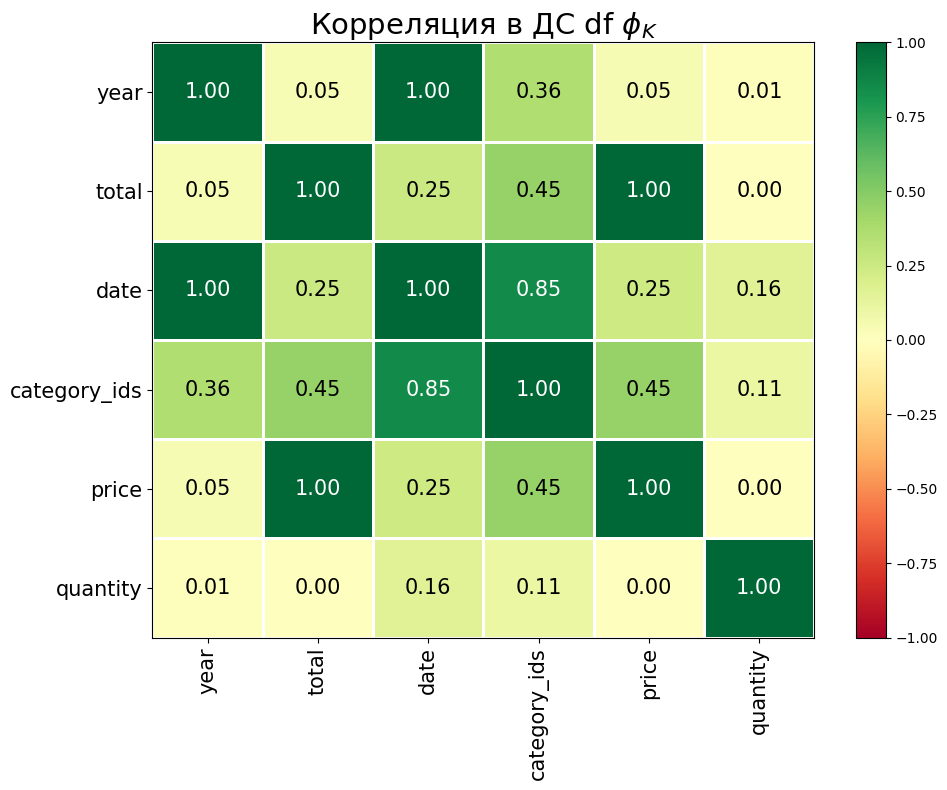

In [289]:
interval_cols = ['quantity', 'price', 'total']

phik_overview = df.drop(['client_id', 'message_id'], axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Корреляция в ДС df $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8))

Отметим, что между столбцами price и total очевидна мультиколлинеарность (что, вероятно вызвано обилием покупок 1 единицы товара), соответственно солбец price необходимо удалить до обучения модели.

Также отметтим сильную связь категории товара и даты. Это не мультиколлинеарная связь, но близка к этому. Возможно это связно с датами акций на определенные категории товаров.

# Разработка модели, 1 версия

Так как в данной задаче требуется предсказать, готов или нет покупатель совершить покупку в ближайшее время, то мы имеем дело с бинарной классификацией (только 2 варианта ответа, да или нет).

В данном случае будем использовать модель градиентного бустинга CatBoost (а именно CatBoostClassifier).

В первой итерации обучим модель в формате "как есть", т.е. используем данные в том формате и объеме, что они есть сейчас.

In [290]:
#Убираем лишние признаки
df = df.drop(['year', 'price'], axis=1)

#Добавляем цедевые признаки из дс target в дс df, дабы размеры выборок совпадали
df = df.merge(target, on = 'client_id', how='left')
df.head()

,client_id,quantity,category_ids,date,message_id,total,target
0,1515915625468169594,1,4,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,0
1,1515915625468169594,1,28,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,0
2,1515915625468169594,1,57,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,0
3,1515915625468169594,1,431,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,0
4,1515915625468169594,1,4,2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0,0


In [332]:
#Делим данные на выборки
RANDOM_STATE = 42

X = df.drop(['client_id', 'message_id', 'target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25, random_state = RANDOM_STATE)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [292]:
cat_features = ['category_ids']

model = CatBoostClassifier(loss_function='Logloss', iterations=50)

model.fit(X_train, y_train, cat_features=cat_features, verbose=10)

Learning rate set to 0.5
0:	learn: 0.3629256	total: 83.3ms	remaining: 4.08s
10:	learn: 0.1416388	total: 784ms	remaining: 2.78s
20:	learn: 0.1394697	total: 1.4s	remaining: 1.93s
30:	learn: 0.1376820	total: 2.02s	remaining: 1.24s
40:	learn: 0.1366429	total: 2.63s	remaining: 577ms
49:	learn: 0.1354531	total: 3.19s	remaining: 0us


In [315]:
prob = model.predict_proba(X_test)
prob_one = prob[:, 1]

print(roc_auc_score(y_test, prob_one))

0.6928218049261399


На текущий момент модель выдает точность в 0,69. Это относительно хороший показатель работы модели (она не ошибается в почти 70% случаев).

Однако попробуем улучшить результаты работы модели.

# Корректировка данных

## Добавление новых данных

Учтем, что есть также данные о рассылках, которые получили клиенты.

In [294]:
messages.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


Обратим внимание, что по одному и тому же клиенту может быть 2 строки с разницей только в действии с сообщением. Вероятно, данная таблица содержит все вариации событий, произошедших с рассылкой.

Для целей текущего проекта нас потенциально интересуют следующие столбцы:
- event - что именно клиент сделал с рассылкой в конечном итоге (т.е. финальное событие)
- channel - по какому каналу клиент получил рассылку.

Т.к. мы предполагаем, что возврат клиента происходит в том числе благодаря маркетинговым рассылкам. Так как нас интересует именно финальное событие (т.к. важен итог), то и в данные включим только последние строки. Кроме того, уберем неважный для нас столбец created_at

In [295]:
last = messages.groupby('message_id').tail(1)

last = last.drop('created_at', axis=1)
last.head()

,bulk_campaign_id,client_id,message_id,event,channel,date
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19


In [296]:
last = last.rename(columns={'date':'mess_date'}).drop(['bulk_campaign_id', 'client_id'], axis=1)
last.head()

,message_id,event,channel,mess_date
0,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19
1,1515915625490086521-4439-62834150016dd,open,email,2022-05-19
3,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19
4,1515915625471518311-4439-628341570c133,open,email,2022-05-19
5,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19


In [297]:
#Объединяет данные
df = df.merge(last, on ='message_id', how='left')
df.head(10)

,client_id,quantity,category_ids,date,message_id,total,target,event,channel,mess_date
0,1515915625468169594,1,4,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,0,NaN,NaN,NaT
1,1515915625468169594,1,28,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,0,NaN,NaN,NaT
2,1515915625468169594,1,57,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,0,NaN,NaN,NaT
3,1515915625468169594,1,431,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,0,NaN,NaN,NaT
4,1515915625468169594,1,4,2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0,0,NaN,NaN,NaT
5,1515915625468169594,1,28,2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0,0,NaN,NaN,NaT
6,1515915625468169594,1,57,2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0,0,NaN,NaN,NaT
7,1515915625468169594,1,431,2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0,0,NaN,NaN,NaT
8,1515915625471138230,1,4,2022-05-16,1515915625471138230-4437-6282242f27843,6499.0,0,NaN,NaN,NaT
9,1515915625471138230,1,28,2022-05-16,1515915625471138230-4437-6282242f27843,6499.0,0,NaN,NaN,NaT


Обратим внимание, что часть клиентов не получала рекламных сообщений, поэтому получены значения NaN и NaT.

Заменим их общим значением.

In [298]:
df['event'] = df['event'].fillna('No')
df['channel'] = df['channel'].fillna('No')

#Пропуски в столбце дата заполним дефолтной датой
rep_date = pd.Timestamp('1900-01-01')
df['mess_date'] = df['mess_date'].fillna(rep_date)

In [299]:
#Перепроверим, что данные не утеряны
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809350 entries, 0 to 809349
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     809350 non-null  int64         
 1   quantity      809350 non-null  int64         
 2   category_ids  809350 non-null  object        
 3   date          809350 non-null  datetime64[ns]
 4   message_id    809350 non-null  object        
 5   total         809350 non-null  float64       
 6   target        809350 non-null  int64         
 7   event         809350 non-null  object        
 8   channel       809350 non-null  object        
 9   mess_date     809350 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 61.7+ MB


## Проверка данных на мультиколлинеарность

Перепроверим, что, с учетом новых данных, мультиколлинеарность отсутствует.

C:\Users\Daria\AppData\Local\Programs\Python\Python312\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable category_ids is large: 1152. Are you sure this is not an interval variable? Analysis for pairs of variables including category_ids can be slow.
  warnings.warn(


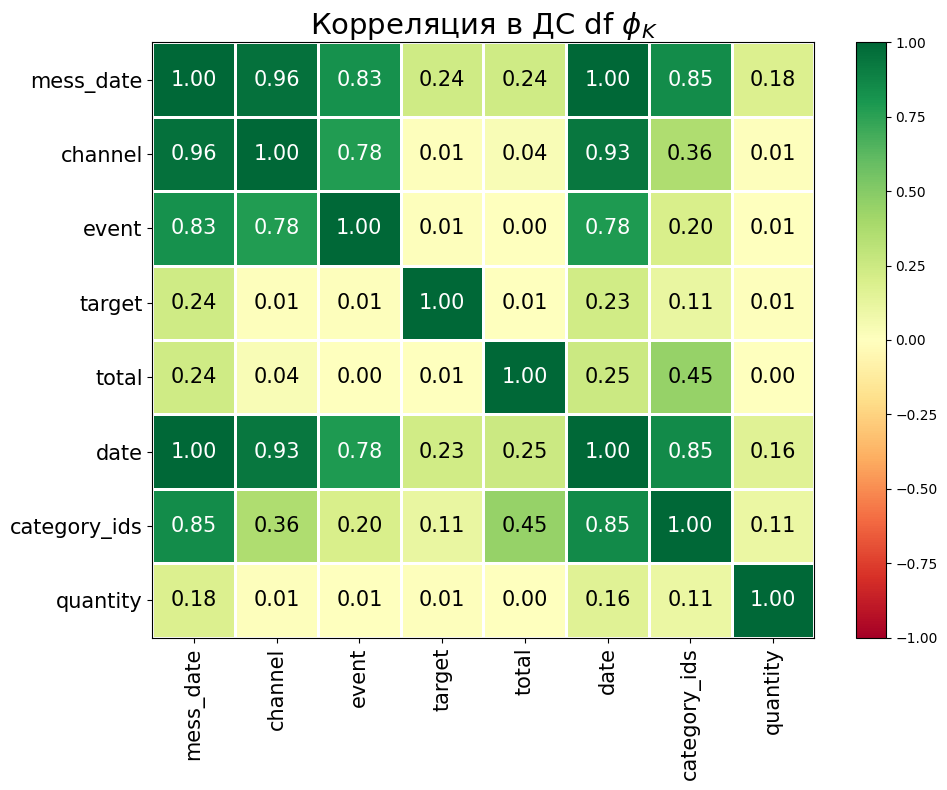

In [300]:
interval_cols = ['quantity', 'price', 'total']

phik_overview = df.drop(['client_id', 'message_id'], axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Корреляция в ДС df $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8))

Отметим, что столбцы date и mess_date имеют максимальную корреляцию между собой. Вероятно, это связано с тем, что полученные рекламные сообщения действительно продуктивно влияют на то, перейдут ли клиенты на сайт и сделают ли покупку. Кроме того, mess_date имеет мультиколлинеарную связь с каналами расссылки, что, вероятно, связано с тем, что разные маркетинговые активности проводятся массово, но в разные дни.

Удалим столбец и оценим данные на мультиколлинеарность еще раз.

C:\Users\Daria\AppData\Local\Programs\Python\Python312\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable category_ids is large: 1152. Are you sure this is not an interval variable? Analysis for pairs of variables including category_ids can be slow.
  warnings.warn(


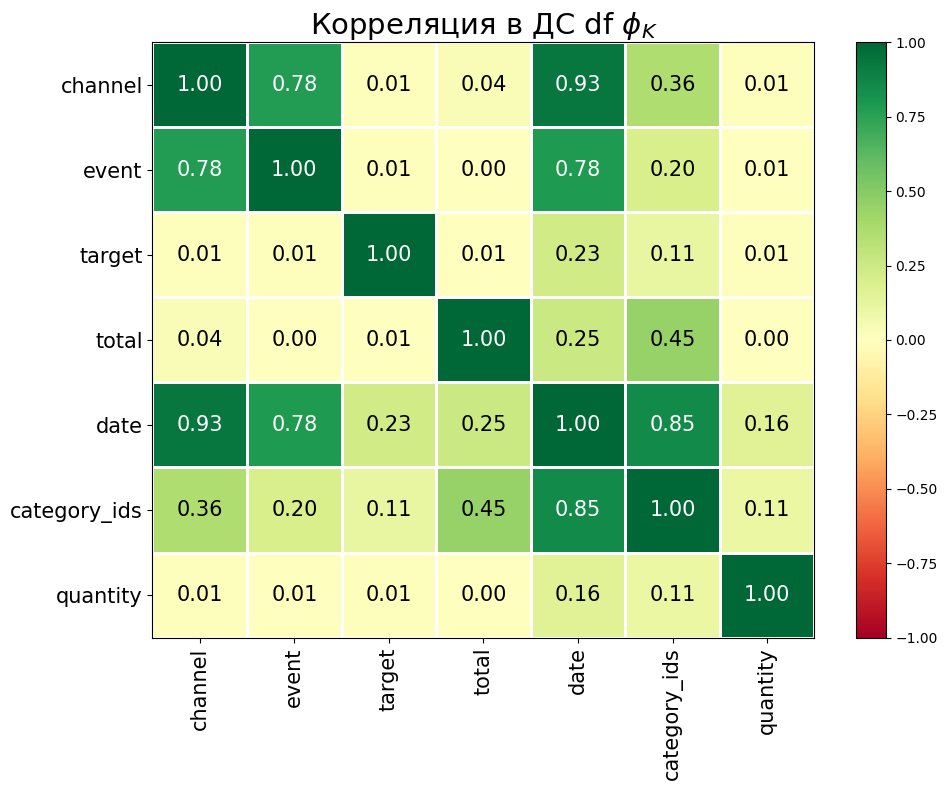

In [301]:
interval_cols = ['quantity', 'price', 'total']

phik_overview = df.drop(['client_id', 'message_id', 'mess_date'], axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Корреляция в ДС df $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8))

Традиционно принято считать, что значения выше 0,9 по модулю свидетельствуют о наличии мультиколлинеарности. Обратим внимание, что столбец date демонстрирует сильную линейную зависимость сразу с несколькими другими столбцами, при этом со столбцом channel эта связь недопустимо высокая.

Отметим, что при этом date имеет большую корреляцию с целевым показателем, чем channel.

Устраним мультиколлинеарность удалением одного из столбцов, однако сделаем это в разных датафреймах. А после дополнительно сравним, какая из моделей покажет себя лучше по метрике.

In [309]:
df_c = df.drop(['date', 'mess_date'], axis=1)
df_d = df.drop(['channel', 'mess_date'], axis=1)

# Разработка модели, 2 версия

Сначала обучим и оценим модель на данных из дф df_c (без даты)

In [310]:
X_c = df_c.drop(['client_id', 'message_id', 'target'], axis=1)
y_c = df_c['target']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_c,
    y_c,
    test_size=0.25, random_state = RANDOM_STATE)

In [314]:
cat_features_c = ['category_ids', 'event', 'channel']

model_c = CatBoostClassifier(loss_function='Logloss', iterations=50)

model_c.fit(X_train_c, y_train_c, cat_features=cat_features_c, verbose=10)

Learning rate set to 0.5
0:	learn: 0.3632010	total: 73ms	remaining: 3.58s
10:	learn: 0.1448178	total: 655ms	remaining: 2.32s
20:	learn: 0.1437456	total: 1.38s	remaining: 1.9s
30:	learn: 0.1432808	total: 2.13s	remaining: 1.31s
40:	learn: 0.1425366	total: 2.88s	remaining: 633ms
49:	learn: 0.1422215	total: 3.56s	remaining: 0us


In [316]:
prob_c = model_c.predict_proba(X_test_c)
prob_one_c = prob_c[:, 1]

print(roc_auc_score(y_test_c, prob_one_c))

0.6435414904939858


Теперь на данных без канала рассылки

In [317]:
X_d = df_d.drop(['client_id', 'message_id', 'target'], axis=1)
y_d = df_d['target']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_d,
    y_d,
    test_size=0.25, random_state = RANDOM_STATE)

In [319]:
cat_features_d = ['category_ids', 'event']

model_d = CatBoostClassifier(loss_function='Logloss', iterations=50)

model_d.fit(X_train_d, y_train_d, cat_features=cat_features_d, verbose=10)

Learning rate set to 0.5
0:	learn: 0.3630861	total: 93.5ms	remaining: 4.58s
10:	learn: 0.1421388	total: 783ms	remaining: 2.78s
20:	learn: 0.1395631	total: 1.48s	remaining: 2.04s
30:	learn: 0.1379077	total: 2.17s	remaining: 1.33s
40:	learn: 0.1357447	total: 2.87s	remaining: 631ms
49:	learn: 0.1347489	total: 3.49s	remaining: 0us


In [320]:
prob_d = model_d.predict_proba(X_test_d)
prob_one_d = prob_d[:, 1]

print(roc_auc_score(y_test_d, prob_one_d))

0.6991980518792715


За счет добавления данных о действии с рассылкой и сохранением даты удалось улучшить работу модели на 0,64%.

Это наилучший результат из трех моделей, однако попробуем его улучшить корректировкой гиперпараметров модели. Увеличим максимальное количество построенных деревьев вдвое.

In [323]:
model_d = CatBoostClassifier(loss_function='Logloss', iterations=100)

model_d.fit(X_train_d, y_train_d, cat_features=cat_features_d, verbose=10)

prob_d = model_d.predict_proba(X_test_d)
prob_one_d = prob_d[:, 1]

print(roc_auc_score(y_test_d, prob_one_d))

Learning rate set to 0.5
0:	learn: 0.3630861	total: 73.6ms	remaining: 7.29s
10:	learn: 0.1421388	total: 778ms	remaining: 6.29s
20:	learn: 0.1395631	total: 1.44s	remaining: 5.42s
30:	learn: 0.1379077	total: 2.1s	remaining: 4.68s
40:	learn: 0.1357447	total: 2.77s	remaining: 3.98s
50:	learn: 0.1347098	total: 3.42s	remaining: 3.28s
60:	learn: 0.1331026	total: 4.08s	remaining: 2.61s
70:	learn: 0.1317877	total: 4.75s	remaining: 1.94s
80:	learn: 0.1306207	total: 5.4s	remaining: 1.27s
90:	learn: 0.1297628	total: 6.07s	remaining: 600ms
99:	learn: 0.1291712	total: 6.69s	remaining: 0us
0.7367479787521362


Это дало прибавку в 3,75% к предыдущему лучшему результату. Так как модель все еще обучается быстро, то увеличим параметр iterations еще вдвое.

In [324]:
model_d = CatBoostClassifier(loss_function='Logloss', iterations=200)

model_d.fit(X_train_d, y_train_d, cat_features=cat_features_d, verbose=10)

prob_d = model_d.predict_proba(X_test_d)
prob_one_d = prob_d[:, 1]

print(roc_auc_score(y_test_d, prob_one_d))

Learning rate set to 0.5
0:	learn: 0.2265108	total: 106ms	remaining: 21.2s
10:	learn: 0.1392682	total: 1.82s	remaining: 31.3s
20:	learn: 0.1373218	total: 3.56s	remaining: 30.3s
30:	learn: 0.1355203	total: 5.33s	remaining: 29s
40:	learn: 0.1335581	total: 7.23s	remaining: 28.1s
50:	learn: 0.1319708	total: 9.14s	remaining: 26.7s
60:	learn: 0.1302709	total: 11s	remaining: 25s
70:	learn: 0.1291383	total: 12.9s	remaining: 23.4s
80:	learn: 0.1278643	total: 14.7s	remaining: 21.6s
90:	learn: 0.1267666	total: 16.5s	remaining: 19.8s
100:	learn: 0.1256398	total: 18.4s	remaining: 18.1s
110:	learn: 0.1247885	total: 20.2s	remaining: 16.2s
120:	learn: 0.1235166	total: 22.1s	remaining: 14.4s
130:	learn: 0.1221377	total: 24s	remaining: 12.7s
140:	learn: 0.1212975	total: 26s	remaining: 10.9s
150:	learn: 0.1205447	total: 28.1s	remaining: 9.13s
160:	learn: 0.1198785	total: 30s	remaining: 7.27s
170:	learn: 0.1188473	total: 31.9s	remaining: 5.42s
180:	learn: 0.1183772	total: 33.7s	remaining: 3.54s
190:	learn

Теперь время обучения остается в рамках одной минуты, допустимо быстро, при этом точность возрасла еще на 6,61%. 
Получаем достаточно высокое значение метрики качества при сохранении относительно высокой скорости обучения.

# Оценка значимости признаков

Оценим важность признаков для лучшей модели, построим график важности и рассмотрим его детально.

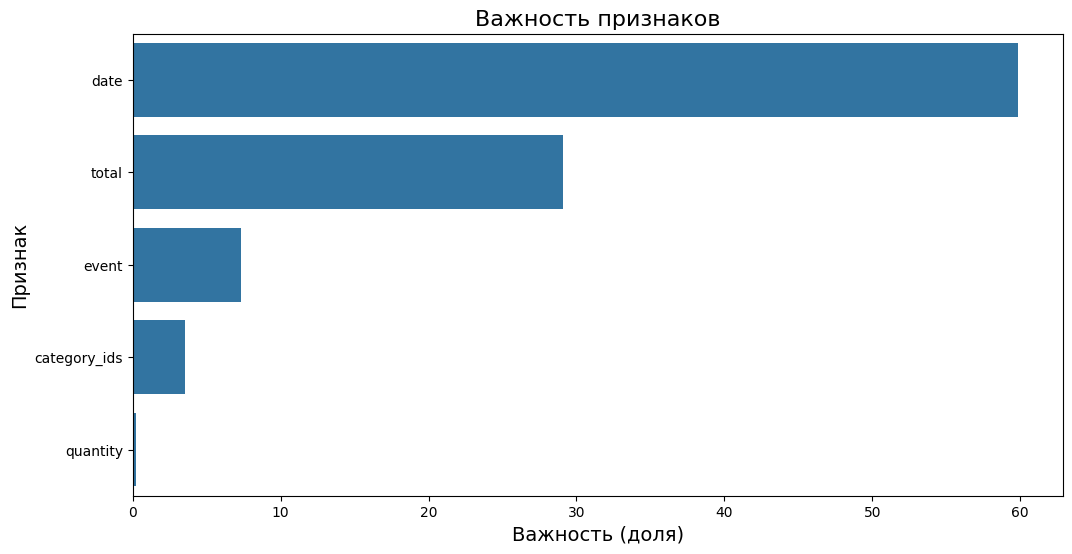

In [330]:
feature_importances = pd.DataFrame(
    {
        'Feature': X_d.columns,
        'Importance': model_d.get_feature_importance()
    }).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importances
)


ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

plt.show()

Отметим, что достаточно ожидаемо наибольшую важность среди признаком имеет date (как отмечали ранее, ряд других данных имеют прямую линейную зависимость от даты).

Наименьшую же важность имеет количество купленных товаров, что также объяснимо: так как большинство клиентво приобретают что-то в единичном количестве, то разброс данных незначителен, соответственно признак не может быть очень значимым.

# Вывод

По итогу проведенного анализа удалось установить следующее:

Общая информация:
- Интернет-магазин демонстрирует рост в товарообороте и выручке (в сравнении данных за 2023 и 2022 года), однако количество уникальных пользователей сокращается.
- Не все клиенты из числа совершивших покупки получали рекламные рассылки.

Дата:
- Дата покупки имеет большое влияние и, в том числе, может повлиять на то, совершит ли клиент повторную покупку в течение 90 дней или нет.
- Вероятно, с учетом выявленной значительной разницы на товары одной и той же категории, это может быть связано с сезонными акциями или индивидуальными предпложениями.
- Так как дата покупки имеет сильную линейную взаимосвязь с датой маркетинговой активности, стоит обратить внимание на даты и время проведения рассылок для достижения наиболее оптимального результата.